In [36]:
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import glob
import random
import time
import matplotlib.pyplot as plt

In [37]:
# Мы создаем класс CustomDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, dir = ''):
        self.imgs_path = dir
        self.data = []

        # Мы добавляем путь к файлу для каждого изображения в список self.data вместе с соответствующим именем класса. 
        for img_path in glob.glob(dir + "*/*.jpg"):
            class_name = img_path.split("\\")[1]
            self.data.append([img_path, class_name])
        
        self.classes = ['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
        self.class_map = {'bill_gates': 0, 'elon_musk': 1, 'jeff_bezos': 2, 'mark_zuckerberg': 3, 'steve_jobs': 4}
        self.img_dim = (224, 224)

        # # Перемешаем данные
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)

        # Словарь self.class_map обеспечивает отображение имени класса в метку.
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [38]:
# Определяем пути к файловым данным
train_path = './CV_project1_data/data/train/'
valid_path = './CV_project1_data/data/valid/'
paths = {'train': train_path, 'val': valid_path}

In [41]:
# Строим датасет и загрузчики данных
train_dataset = CustomDataset(dir=train_path)
valid_dataset = CustomDataset(dir=valid_path)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [43]:
# Сохраняем классы данных
classes = train_dataset.classes
classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

['elon_musk', 'elon_musk', 'elon_musk', 'mark_zuckerberg']


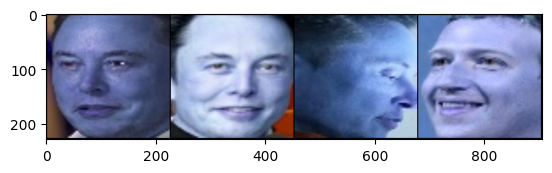

In [56]:
# Отрисуем один батч картинок, загруженных с помощью DataLoader()
X_train, y_train = next(iter(train_loader))
print([classes[i] for i in y_train])
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
plt.imshow(img)

In [45]:
# Определяем модель VGG16
model = vgg16(pretrained = True)
print(model)

d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
# Помним, что заморозка предполагает фиксацию весов модели во время обратного распространения ошибки 
for param in model.parameters():
    param.requires_grad = False

# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи классификации
num_classes = 6
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [49]:
# Будем обучать только добавленный выходной слой классификатора
for index, param in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True

In [50]:
# Определяем есть ли у нас аппаратное ускорение
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

# переводим модель на тип аппарата
model = model.to(device)

# Определяем функции потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

True


In [51]:
# Определяем функцию для тренировки данных

def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидация 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем потери
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(dir=paths[phase]).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(dir=paths[phase]).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [53]:
# Определяем даталоадеры и начинаем тренировку
dataloaders = {'train': train_loader, 'val': valid_loader}
celebrities = train_model(model, device, dataloaders, criterion, optimizer, batch_size = batch_size, num_epochs=5)

Epoch 0/4
----------
Batch 10, Train Loss:1.8439, Train ACC:20.0000
Batch 20, Train Loss:1.6209, Train ACC:25.0000
Batch 30, Train Loss:1.5179, Train ACC:32.5000
Batch 40, Train Loss:1.3910, Train ACC:40.0000
Batch 50, Train Loss:1.3409, Train ACC:43.5000
Batch 60, Train Loss:1.2809, Train ACC:46.2500
Batch 70, Train Loss:1.2491, Train ACC:47.1429
Batch 80, Train Loss:1.2036, Train ACC:49.0625
Batch 90, Train Loss:1.1750, Train ACC:51.3889
Batch 100, Train Loss:1.1304, Train ACC:53.7500
Batch 110, Train Loss:1.0971, Train ACC:55.4545
Batch 120, Train Loss:1.0707, Train ACC:56.2500
Batch 130, Train Loss:1.0546, Train ACC:56.9231
Batch 140, Train Loss:1.0256, Train ACC:58.3929
Batch 150, Train Loss:1.0134, Train ACC:58.8333
Batch 160, Train Loss:0.9963, Train ACC:59.6875
Batch 170, Train Loss:0.9744, Train ACC:60.7353
Batch 180, Train Loss:0.9618, Train ACC:61.3889
Batch 190, Train Loss:0.9394, Train ACC:62.6316
Batch 200, Train Loss:0.9297, Train ACC:63.1250
Batch 210, Train Loss:0.9089

In [54]:
# Пишем метод для визуализации прогнозирования

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

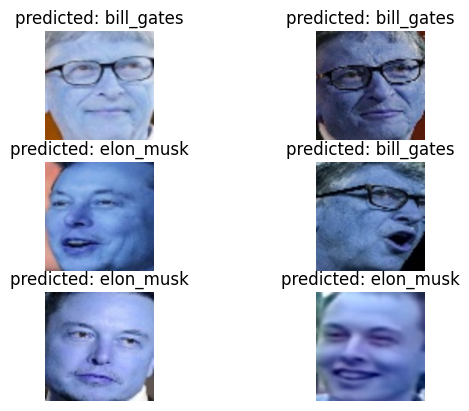

In [55]:
visualize_model(celebrities)
plt.show()